# Linear least squares fit

## Tasks

Perform a least squares fit of a parabola

$$ y(x) = \theta_0 + \theta_1 x + \theta_2 x^2$$

for the seven independent measurments $(x_i, y_erri)$ given by $(-0.75, 1.0 \pm 1.0)$, $(-0.5, 4.0 \pm 1.0)$, $(-0.25, 4.0 \pm 0.5)$, $(0.0, 5.5 \pm 0.5)$, $(0.25, 4.5 \pm 0.5)$, $(0.5, 5.5 \pm 1.0)$, $(0.75, 3.0 \pm 1.0)$. 

a) Determine the best fit parameters $\hat \theta_i$ and their covariances using the formula for linear least squares fits.

b) Determine the $\chi_\mathrm{obs}^2$ for the best fit parameter. What is the number of degrees of freedom? Plot the $\chi^2$ distribution and indicate $\chi_\mathrm{obs}^2$ in this plot (e.g. by drawing a line at this value).
What is the $p$-value for this fit?

c) Plot the fitted parabola and the $1\sigma$ error band around it as obtaind from the error propagation formula $\sigma_y^2 = A^\mathrm{T} U A$. What is the predicted value $y$ at $x=1$ and its uncertainty?

d) Compare the fit result and the covariance matrix with the results obtained with iminuit. Do the results agree?

e) Determine the $p$-value for a straight-line fit. Is this an acceptable description of the data? Repeat part a) b) c) but for straight line


### Hints

1) The following numpy functions might come in very handy
* diagonal matrix from vector v in numpy: *A = np.diagflat(v)*
* matrix from column vectors v0, v1, v2: *A = np.column_stack((v0, v1, v2))*
* multiplication of matrices A and B in numpy: *C = A.dot(B)*
* transposed matrix: *A_T = np.transpose(A)*
* inverse matrix: *A_inv = inv(A)*, this requires *from numpy.linalg import inv*

2) It might be useful to write a function which returns the uncertainty $\sigma_y$ for a numpy array of $x$ values. A function $f$ that only works for a scalar value $x$ can be vectorized (i.e., it works also for numpy arrays) with *numpy.vectorize*.

3) Data points with error bars can be drawn with *plt.errorbar(x, y, yerr=sigma_y)*

4) A band between $y$ values can be drawn with the aid of *matplotlib.pyplot.fill_between*

## Solution

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from iminuit import Minuit
from scipy.optimize import curve_fit
from scipy.stats import chi2
from IPython.display import display, Latex

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = 8, 8
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.facecolor"] = (1., 1., 1.)
plt.rcParams["axes.edgecolor"] = (.0, .0, .0)
plt.rcParams["scatter.marker"] = "."
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["grid.color"] = (0.6, 0.6, 0.6)
plt.rcParams["grid.linestyle"] = (3, 1)
plt.rcParams["legend.facecolor"] = (1., 1., 1.)
plt.rcParams["legend.fontsize"] = 7
plt.rcParams["font.family"] = "serif"
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["xtick.labeltop"] = False
plt.rcParams["xtick.labelsize"] = 7.5
plt.rcParams["ytick.labelsize"] = 7.5
plt.rcParams["ytick.labelleft"] = True
plt.rcParams["ytick.left"] = False

#packages and plot styles

def f(x, p0=0, p1=0, p2=0):
    return p0 + p1 * x + p2 * x**2


def matrix_string(M, name):
    string = f"${name}"+r" = \begin{pmatrix}"
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            string += f"{M[i,j]:.2f}"
            if j < M.shape[1]-1:
                string += "&"
        if i < M.shape[0]-1:
            string += "\\\\"
    string += "\end{pmatrix}$"
    return string


def task_a(x, y, y_err, m, k=2):
    n = y.shape[0]
    C, A = np.diagflat(y_err**2), x**np.array([0,1,k])
    G = inv(A.T @ inv(C) @ A) @ A.T @ inv(C)
    lam, C_lam = G @ y, G@C@G.T

    display(Latex(matrix_string(lam, "\lambda")+", "+matrix_string(C_lam, "C_{\lambda}")))
    return lam, C_lam, A, n


def task_b(y, lam, C_lam, A, n, m):
    C = np.diagflat(y_err**2)
    dof, z = n - m, np.linspace(0, 30, 1000)
    chi2_obs = ( (y - A @ lam).T @ inv(C) @ (y - A @ lam) )[0,0]
    pdf, p = chi2.pdf(z, dof), 1 - chi2.cdf(chi2_obs, dof)

    display(Latex(r"$\chi^2_{obs} = "+f"{chi2_obs:.2f}$, $dof = "+f"{dof:.0f}$"))
    display(Latex(f"$p = {p:.2f}$"))

    fig, ax = plt.subplots(1)
    ax.fill_between(z, pdf, alpha=.3, color="r")
    ax.plot(z, pdf, "r-", label=f"f(z=$\chi^2$, dof={dof})")
    ax.vlines(chi2_obs, 0, pdf.max()*1.1, label=r"$\chi^2_{obs}$"+f" = {chi2_obs:.2f}")
    ax.set_title(f"$\chi^2$ distribution with {dof} degrees of freedom")
    ax.set_xlim(z.min(), z.max())
    ax.set_ylim(0, pdf.max()*1.1)
    ax.set_ylabel(f"f(z=$\chi^2$, dof={dof})")
    ax.set_xlabel(r"$\chi^2$")
    ax.legend()
    plt.show()
    pass
    
def task_c(x, y, y_err, C_lam, lam):
    x_range = np.full((1,1000), np.linspace(np.floor(x.min()), np.ceil(x.max()), 1000)).T
    A = (x_range**np.arange(m)).T
    y_errcov = np.sqrt(np.diag(A.T @ C_lam @ A))
    print(y_errcov)

    fig, ax = plt.subplots(1)
    ax.errorbar(x, y, yerr=y_err[:,0], ls="", capsize=5, color="tab:orange", marker=".", label="Data")
    ax.plot(x_range, f(x_range, *lam), color="tab:blue", lw=.5, label="Best-Fit")
    ax.fill_between(x_range[:,0], f(x_range, *lam)[:,0]-y_errcov, f(x_range, *lam)[:,0]+y_errcov, color="tab:blue", alpha=.3, label=r"$1\sigma$-Band")
    # ax.set_title("Fitted Parabola with 1$\sigma$-Band")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    plt.show()

    x1 = np.ones((1,1))
    A = (x1**np.arange(m)).T
    y_errcov = np.sqrt(np.diag(A.T @ C_lam @ A))
    display(Latex(f"For $x=1$ : $y=f(x=1)={f(x1, *lam)[0,0]:.2f}\pm{y_errcov[0]:.2f}$"))
    pass

x = np.array([[-0.75, -0.5, -0.25, 0., 0.25, 0.5, 0.75]]).T
y = np.array([[1., 4.0, 4., 5.5, 4.5, 5.5, 3.]]).T
y_err = np.array([[1., 1., 0.5, 0.5, 0.5, 1., 1.]]).T

In [13]:
m = 3
display(Latex("a)"))
lam, C_lam, A, n = task_a(x, y, y_err, m, k=2)
lam, C_lam, A, n = task_a(x, y, y_err, m, k=3)
lam, C_lam, A, n = task_a(x, y, y_err, m, k=4)

<IPython.core.display.Latex object>

NameError: name 'k' is not defined

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

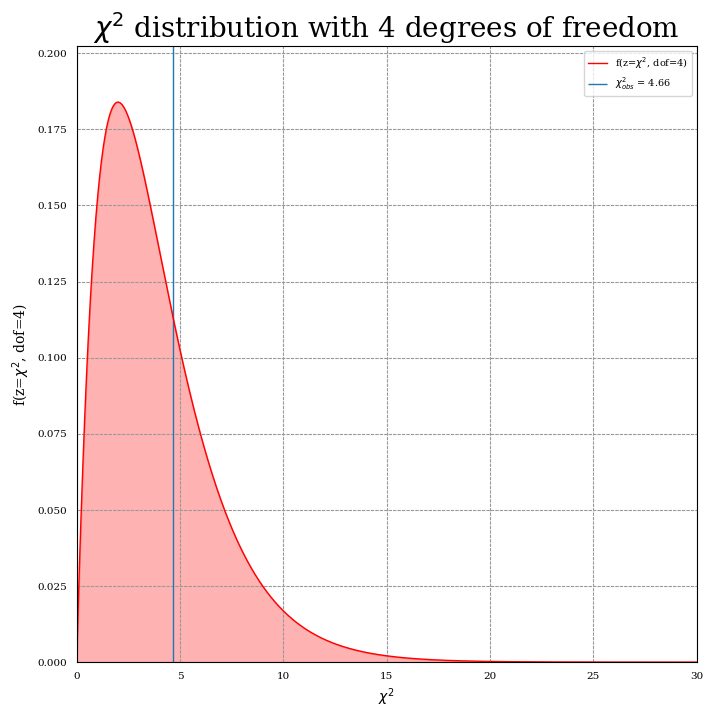

In [10]:
display(Latex("b)"))
task_b(y, lam, C_lam, A, n, m)

<IPython.core.display.Latex object>

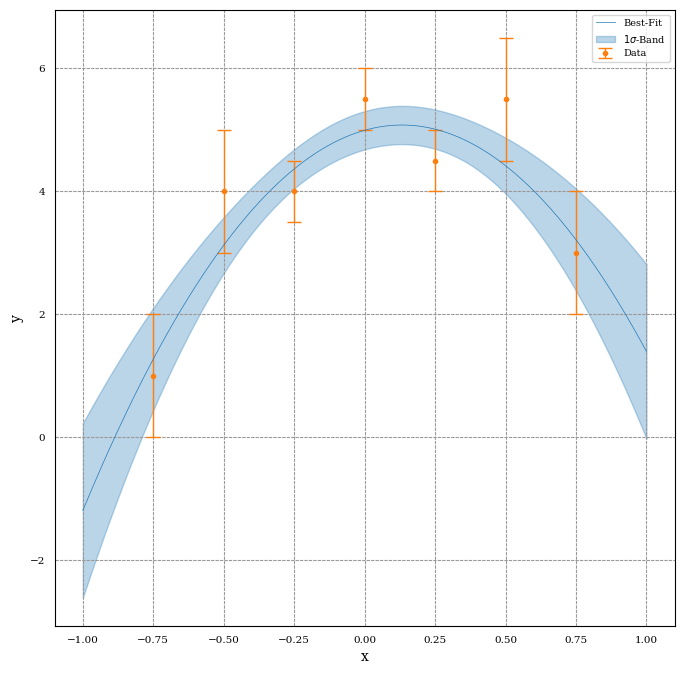

<IPython.core.display.Latex object>

In [11]:
display(Latex("c)"))
task_c(x, y, y_err, C_lam, lam)

In [12]:
def f_min(p0, p1, p2):
    return np.sum((y - f(x, p0, p1, p2))**2 / y_err**2)

minimizer_f = Minuit(f_min, p0=1, p1=1, p2=1, error_p0=.1, error_p1=.1, error_p2=.1, errordef=1)
display(Latex("d)"))
display(minimizer_f.migrad())
display(minimizer_f.matrix())

RuntimeError: error_p0 is not one of the parameters [p0 p1 p2]

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

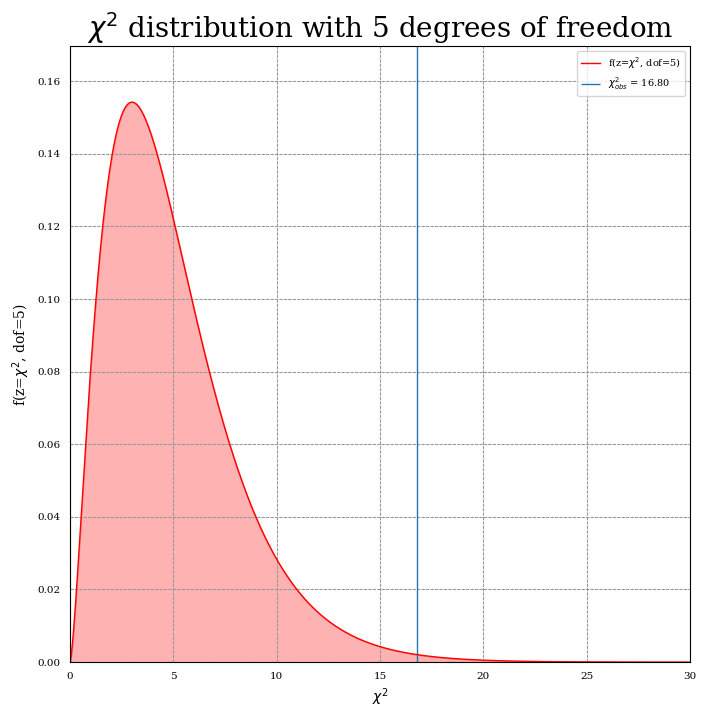

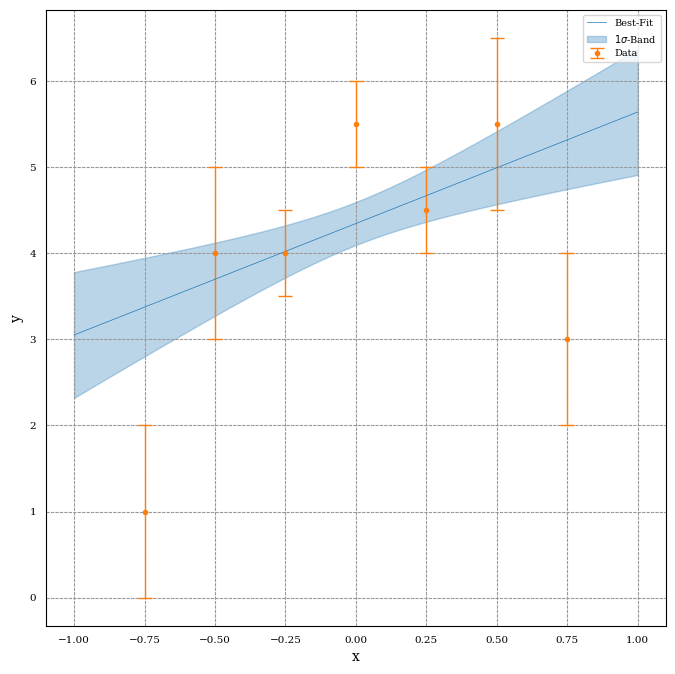

<IPython.core.display.Latex object>

In [ ]:
m = 2
display(Latex("e)"))
lam, C_lam, A, n = task_a(x, y, y_err, m)
task_b(y, lam, C_lam, A, n, m)
task_c(x, y, y_err, C_lam, lam)